 🚖 NYC Yellow Taxi — PySpark End-to-End Project

This notebook demonstrates an end-to-end big data pipeline using *PySpark* to process, analyze, and model the NYC Yellow Taxi dataset.  
It includes:
- Environment setup and dataset download
- Data ingestion and cleaning
- Feature engineering
- Spark SQL exploration
- MLlib regression, classification, and clustering
- Model export and visualizations

***Environment and dataset download***

### Environment Setup & Data Download
Install required libraries, configure Kaggle API credentials, and download the NYC Yellow Taxi dataset for analysis.

In [7]:
# --- Install libraries ---
!pip -q install pyspark==3.5.1 kaggle==1.6.17 pyngrok==7.2.0 plotly==5.22.0

# --- Write your kaggle.json securely, set perms, and download data ---
import os, json, subprocess, textwrap

# 1) Create kaggle.json from your credentials (WARNING: secrets are visible in notebook history)
os.makedirs("/root/.kaggle", exist_ok=True)
kaggle_creds = {
    "username": "manjotshambi",
    "key": "93fdd4c1b98ee7fb1d0fd4322421ccd8"
}
with open("/root/.kaggle/kaggle.json", "w") as f:
    json.dump(kaggle_creds, f)
os.chmod("/root/.kaggle/kaggle.json", 0o600)
print("✅ kaggle.json written for user:", kaggle_creds["username"])

# 2) Dataset + files to fetch (edit to add more months)
KAGGLE_DATASET = "elemento/nyc-yellow-taxi-trip-data"
FILES_TO_GET = [
    "yellow_tripdata_2015-01.csv",   # add more like "yellow_tripdata_2016-01.csv"
]

# 3) Ensure data dir exists
DATA_DIR = "/content/data"
os.makedirs(DATA_DIR, exist_ok=True)

# 4) List and download specific files
print("Listing dataset files…")
!kaggle datasets files $KAGGLE_DATASET -p /content -q

print("Downloading selected files…")
for fname in FILES_TO_GET:
    # download zip (or raw csv depending on dataset packaging)
    subprocess.run(
        ["kaggle", "datasets", "download", KAGGLE_DATASET, "-f", fname, "-p", "/content", "-q"],
        check=True
    )
    zip_path = f"/content/{fname}.zip"
    raw_path = f"/content/{fname}"
    if os.path.exists(zip_path):
        subprocess.run(["unzip", "-q", "-o", zip_path, "-d", DATA_DIR], check=True)
    elif os.path.exists(raw_path):
        subprocess.run(["mv", raw_path, DATA_DIR], check=True)

print("✅ Files in /content/data:")
!ls -lh /content/data | head -n 50



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 98.4 MB/s eta 0:00:00
✅ kaggle.json written for user: manjotshambi
Listing dataset files…
usage: kaggle [-h] [-v] [-W]
              {competitions,c,datasets,d,kernels,k,models,m,files,f,config}
              ...
kaggle: error: unrecognized arguments: -p /content -q
✅ Files in /content/data:
total 1.9G
-rw-r--r-- 1 root root 1.9G Dec  9  2021 yellow_tripdata_2015-01.csv


***Start Spark***

### Start Spark Session
Initialize a PySpark SparkSession for the NYC Yellow Taxi project, which serves as the entry point for running Spark SQL, DataFrame operations, and MLlib tasks.

In [8]:

from pyspark.sql import SparkSession
spark = (SparkSession.builder
         .appName("NYC Yellow Taxi — End-to-End")
         .config("spark.ui.showConsoleProgress","false")
         .getOrCreate())
spark

***Ingest CSV , Data Frame, Basic cleaning, parquet Cache***

### Ingest CSV, Create DataFrame, and Basic Cleaning
Define the schema for the NYC Yellow Taxi dataset, read the CSV into a Spark DataFrame, perform basic cleaning, and cache the data in Parquet format for faster processing in later steps.

In [9]:
from pyspark.sql.types import *
from pyspark.sql.functions import *

schema = StructType([
    StructField("VendorID", IntegerType(), True),
    StructField("tpep_pickup_datetime", TimestampType(), True),
    StructField("tpep_dropoff_datetime", TimestampType(), True),
    StructField("passenger_count", IntegerType(), True),
    StructField("trip_distance", DoubleType(), True),
    StructField("pickup_longitude", DoubleType(), True),
    StructField("pickup_latitude", DoubleType(), True),
    StructField("RatecodeID", IntegerType(), True),
    StructField("store_and_fwd_flag", StringType(), True),
    StructField("dropoff_longitude", DoubleType(), True),
    StructField("dropoff_latitude", DoubleType(), True),
    StructField("payment_type", IntegerType(), True),
    StructField("fare_amount", DoubleType(), True),
    StructField("extra", DoubleType(), True),
    StructField("mta_tax", DoubleType(), True),
    StructField("tip_amount", DoubleType(), True),
    StructField("tolls_amount", DoubleType(), True),
    StructField("improvement_surcharge", DoubleType(), True),
    StructField("total_amount", DoubleType(), True)
])

csv_path = "/content/data/yellow_tripdata_2015-01.csv"
df_raw = (spark.read
          .option("header","true")
          .schema(schema)
          .csv(csv_path))

print("Rows:", df_raw.count())
df_raw.printSchema()
df_raw.show(5, truncate=False)

df_clean = (df_raw
    .filter(col("trip_distance").between(0.1, 50.0))
    .filter(col("fare_amount").between(2.5, 300.0))
    .filter(col("passenger_count").between(1, 6))
    .filter(col("pickup_longitude").between(-75, -72))
    .filter(col("dropoff_longitude").between(-75, -72))
    .filter(col("pickup_latitude").between(40, 42))
    .filter(col("dropoff_latitude").between(40, 42))
    .withColumn("duration_min", (unix_timestamp("tpep_dropoff_datetime") - unix_timestamp("tpep_pickup_datetime"))/60.0)
    .filter(col("duration_min").between(1, 180))
)

print("Clean rows:", df_clean.count())
PARQUET_DIR = "/content/parquet/2015_01_clean"
df_clean.repartition(8).write.mode("overwrite").parquet(PARQUET_DIR)
df = spark.read.parquet(PARQUET_DIR).cache()
df.count()

Rows: 12748986
root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)

+--------+--------------------+---------------------+---------------+-------------+------------------+

12375968

***RDDs(map, filter, reduce)***

### RDD Operations (map, filter, reduce)
Load the CSV file as an RDD, separate the header from the data, and perform basic transformations to inspect the average number of columns per row. This step demonstrates raw RDD operations like map, filter, and reduce before moving to Spark SQL.

In [10]:
rdd = spark.read.text(csv_path).rdd
header = rdd.first()[0]
non_header = rdd.filter(lambda row: row[0] != header)
avg_cols = non_header.map(lambda r: len(r[0].split(","))).mean()
print("Approx avg columns:", avg_cols)


Approx avg columns: 19.0


***Spark SQL exploration***

### Spark SQL Exploration
Create a temporary view of the trips DataFrame and run SQL queries to explore the dataset. Example queries include calculating daily trip counts, average fare, and average trip distance using Spark SQL syntax.

In [11]:
df.createOrReplaceTempView("trips")

daily = spark.sql("""
SELECT DATE(tpep_pickup_datetime) AS d,
       COUNT(*) AS trips,
       ROUND(AVG(fare_amount),2) AS avg_fare,
       ROUND(AVG(trip_distance),2) AS avg_dist
FROM trips
GROUP BY DATE(tpep_pickup_datetime)
ORDER BY d
""")
daily.show(10)
pdf = daily.toPandas()

+----------+------+--------+--------+
|         d| trips|avg_fare|avg_dist|
+----------+------+--------+--------+
|2015-01-01|368950|   12.66|    3.26|
|2015-01-02|334693|   12.06|    2.97|
|2015-01-03|395840|   11.58|    2.85|
|2015-01-04|320497|   12.63|    3.34|
|2015-01-05|352696|   12.15|    3.04|
|2015-01-06|372708|   11.78|    2.73|
|2015-01-07|417148|   11.43|    2.64|
|2015-01-08|436906|   11.64|    2.66|
|2015-01-09|434198|   11.94|    2.72|
|2015-01-10|499254|   11.31|    2.65|
+----------+------+--------+--------+
only showing top 10 rows



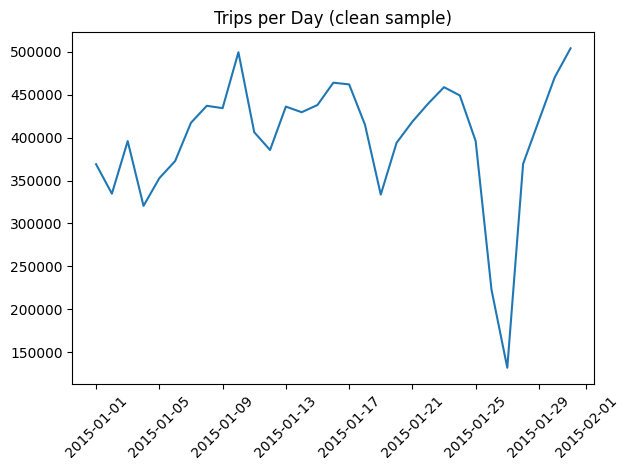

In [12]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(pdf["d"], pdf["trips"])
plt.title("Trips per Day (clean sample)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

***Feature Engineering(time, haversine, speed)***

### Feature Engineering (Time, Haversine Distance, Speed)
Create new features to enhance model performance:
- *Hour* and *Day of Week* extracted from pickup datetime.
- *Is Weekend* flag based on day of week.
- *Geo Distance* calculated using the haversine formula from pickup and dropoff coordinates.
- *Speed (mph)* computed from distance and trip duration.
Apply data quality filters to remove invalid distances, nulls, and unrealistic speeds, then cache the processed DataFrame.

In [13]:
from math import radians, cos, sin, asin, sqrt
from pyspark.sql.functions import udf, dayofweek, when, col, hour

@udf("double")
def haversine(lon1, lat1, lon2, lat2):
    if None in (lon1, lat1, lon2, lat2):
        return None
    lon1, lat1, lon2, lat2 = map(float, (lon1, lat1, lon2, lat2))
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 3958.8  # miles
    return float(c * r)

# dayofweek(): 1 = Sunday ... 7 = Saturday
df_fe = (df
   .withColumn("hour", hour("tpep_pickup_datetime"))
   .withColumn("dow", dayofweek("tpep_pickup_datetime"))
   .withColumn("is_weekend", when(col("dow").isin([1, 7]), 1).otherwise(0))
   .withColumn("geo_distance", haversine("pickup_longitude","pickup_latitude",
                                        "dropoff_longitude","dropoff_latitude"))
   .withColumn("speed_mph", col("geo_distance") / (col("duration_min")/60.0))
   .filter(col("geo_distance").isNotNull())
   .filter(col("speed_mph").between(0.5, 80))
).cache()

df_fe.select("geo_distance","duration_min","speed_mph","hour","dow","is_weekend").show(5)
df_fe.count()



+------------------+------------------+-----------------+----+---+----------+
|      geo_distance|      duration_min|        speed_mph|hour|dow|is_weekend|
+------------------+------------------+-----------------+----+---+----------+
| 1.172199656276616|             15.65|4.494056190197888|  21|  6|         0|
| 2.135029490734319| 6.966666666666667|18.38781379579796|  12|  1|         1|
| 2.810721992317493|18.166666666666668|9.283118506736674|  16|  7|         1|
|0.6794406929087277| 8.166666666666666|4.991809172390653|  21|  4|         0|
|0.5630623223707758| 6.666666666666667|5.067560901336982|  17|  4|         0|
+------------------+------------------+-----------------+----+---+----------+
only showing top 5 rows



12293451

***MLlib Regression(fare), classification(high_tip), clustering(KMeans)***

### MLlib Regression, Classification, and Clustering
Set up Spark MLlib workflows for:
- *Regression*: Predicting fare amount.
- *Classification*: Predicting high_tip (0/1).
- *Clustering*: Grouping trips using KMeans based on location and trip metrics.
This section installs/sets up the required Spark environment in Colab and initializes a Spark session for running MLlib models.

In [1]:
# ========= COLAB: Clean Spark install + fixed ports + smoke test =========
!pip -q uninstall -y pyspark py4j dataproc-spark-connect google-cloud-dataproc || true
!apt-get -yqq install openjdk-17-jdk-headless >/dev/null

import os, glob, shutil, gc, sys
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
os.environ["SPARK_LOCAL_IP"] = "127.0.0.1"
os.environ["JAVA_TOOL_OPTIONS"] = "-Djava.net.preferIPv4Stack=true"
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

!pip -q install --no-cache-dir pyspark==3.5.1

for p in glob.glob('/content/spark-*'): shutil.rmtree(p, ignore_errors=True)
shutil.rmtree('/content/spark-temp', ignore_errors=True)
os.makedirs('/content/spark-temp', exist_ok=True); gc.collect()

from pyspark.sql import SparkSession
spark = (SparkSession.builder
    .appName("spark-smoke-test")
    .master("local[1]")
    .config("spark.ui.enabled","false")
    .config("spark.driver.bindAddress","127.0.0.1")
    .config("spark.driver.host","127.0.0.1")
    .config("spark.driver.port","30001")        # fixed ports
    .config("spark.blockManager.port","30002")
    .config("spark.port.maxRetries","0")
    .config("spark.local.dir","/content/spark-temp")
    .getOrCreate())
print("✅ Spark started:", spark.version)
print("Count:", spark.range(10).count())
spark.stop()



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 181.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 192.0 MB/s eta 0:00:00
✅ Spark started: 3.5.1
Count: 10


In [15]:

# === ML: Regression (Decision Tree), Classification (LogReg), Clustering (KMeans) ===
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import (
    RegressionEvaluator,
    BinaryClassificationEvaluator,
    MulticlassClassificationEvaluator
)

# Base DF for ML (add binary label for classification)
ml_base = df_fe.withColumn("high_tip", (col("tip_amount") >= 2.0).cast("int")).cache()

# ---------------- Regression (predict fare_amount) ----------------
reg_features = ["geo_distance", "duration_min", "speed_mph", "hour", "is_weekend", "passenger_count"]
reg_va = VectorAssembler(inputCols=reg_features, outputCol="features")
reg_model = DecisionTreeRegressor(featuresCol="features", labelCol="fare_amount", maxDepth=8)
reg_pipeline = Pipeline(stages=[reg_va, reg_model])

train_reg, test_reg = ml_base.filter(col("fare_amount").isNotNull()).randomSplit([0.8, 0.2], seed=42)
reg_fitted = reg_pipeline.fit(train_reg)
reg_preds = reg_fitted.transform(test_reg)

reg_rmse = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse").evaluate(reg_preds)
reg_r2   = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="r2").evaluate(reg_preds)
print(f"Regression — RMSE: {reg_rmse:.2f}, R2: {reg_r2:.3f}")

# ---------------- Classification (predict high_tip) ----------------
cls_features = ["geo_distance", "duration_min", "speed_mph", "hour", "is_weekend", "passenger_count", "fare_amount"]
cls_va = VectorAssembler(inputCols=cls_features, outputCol="features")
logit = LogisticRegression(featuresCol="features", labelCol="high_tip", maxIter=20)
cls_pipeline = Pipeline(stages=[cls_va, logit])

train_cls, test_cls = ml_base.filter(col("high_tip").isNotNull()).randomSplit([0.8, 0.2], seed=7)
cls_fitted = cls_pipeline.fit(train_cls)
cls_preds = cls_fitted.transform(test_cls)

auc = BinaryClassificationEvaluator(labelCol="high_tip", rawPredictionCol="rawPrediction").evaluate(cls_preds)
acc = MulticlassClassificationEvaluator(labelCol="high_tip", predictionCol="prediction", metricName="accuracy").evaluate(cls_preds)
print(f"Classification — AUC: {auc:.3f}, Accuracy: {acc:.3f}")

# ---------------- Clustering (KMeans on pickup lon/lat) ----------------
# NOTE: In PySpark 3.5+, clusterCenters() returns numpy arrays -> use .tolist(), not .toArray()
pickups = (ml_base
           .select(col("pickup_longitude").cast("double").alias("lon"),
                   col("pickup_latitude").cast("double").alias("lat"))
           .dropna()
           .filter(col("lon").between(-75, -72))
           .filter(col("lat").between(40, 42)))

km_va = VectorAssembler(inputCols=["lon", "lat"], outputCol="features")
kmeans = KMeans(k=6, seed=123)

km_df = km_va.transform(pickups)
km_model = kmeans.fit(km_df)

centroids = [tuple(c.tolist()) for c in km_model.clusterCenters()]
print("KMeans centers (lon, lat):", centroids)




Regression — RMSE: 2.56, R2: 0.929
Classification — AUC: 0.806, Accuracy: 0.733
KMeans centers (lon, lat): [(-73.96054052259049, 40.7799316523685), (-73.7845985461505, 40.64665678335259), (-73.98178639805909, 40.75659465786761), (-73.99694521715469, 40.729737790633976), (-73.96947774238643, 40.69493429573651), (-73.87458880366145, 40.76871656871055)]


***Saved Trained pipelines for frontend***

### Save Trained Pipelines for Frontend
Save the trained regression and classification models into the models directory.  
These models will be used by the frontend application to make predictions without retraining.

In [16]:
MODELS_DIR = "/content/models"
reg_path = f"{MODELS_DIR}/fare_regression_dt"
cls_path = f"{MODELS_DIR}/high_tip_logreg"

import shutil, os
shutil.rmtree(MODELS_DIR, ignore_errors=True)
os.makedirs(MODELS_DIR, exist_ok=True)

reg_fitted.write().overwrite().save(reg_path)
cls_fitted.write().overwrite().save(cls_path)
print("Saved to:", MODELS_DIR)

Saved to: /content/models


***Visualizations( matplotlib and plotly)***

### Visualization (Matplotlib & Plotly)
Generate data visualizations to explore trip patterns:
- *Scatter Plot*: Fare amount vs. trip distance.
- *Histogram*: Distribution of trips by hour.
These charts help validate data quality and reveal trends in the dataset.

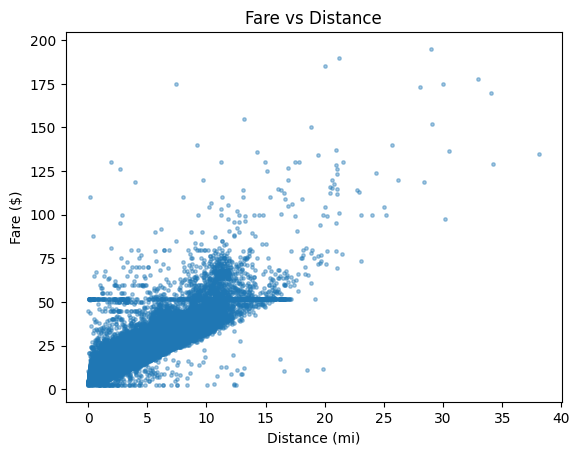

In [17]:
import pandas as pd, plotly.express as px, matplotlib.pyplot as plt

sample_pd = (df_fe
             .select("hour","fare_amount","geo_distance","duration_min","speed_mph")
             .sample(False, 0.02, seed=10)
             .toPandas())

plt.figure()
plt.scatter(sample_pd["geo_distance"], sample_pd["fare_amount"], s=6, alpha=0.4)
plt.xlabel("Distance (mi)"); plt.ylabel("Fare ($)"); plt.title("Fare vs Distance")
plt.show()

fig = px.histogram(sample_pd, x="hour", nbins=24, title="Trips by Hour (sample)")
fig.show()


***Export predictions to CSV***

### Export Predictions to CSV
Select key columns, including model predictions and probabilities, and save them as a CSV file for further analysis or integration into the frontend.  
If running in Google Colab, automatically trigger the file download.

In [18]:
predictions = (cls_preds
               .select("fare_amount","tip_amount","high_tip","prediction","probability","geo_distance","duration_min")
               .limit(5000))
out_csv = "/content/high_tip_predictions_sample.csv"
predictions.toPandas().to_csv(out_csv, index=False)
print("Saved:", out_csv)

try:
    from google.colab import files
    files.download(out_csv)
except Exception as e:
    print("If not in Colab, manually download:", out_csv)

Saved: /content/high_tip_predictions_sample.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>